In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bengali-gtl/data.tsv


# Loading the Dataset

In [2]:
import pandas as pd

data_path = '/kaggle/input/bengali-gtl/data.tsv'
data = pd.read_csv(data_path, delimiter='\t', header=None, names=["Token", "POS", "NER"])

In [3]:
data

,Token,POS,NER
0,শনিবার (২৭ আগস্ট) রাতে পটুয়াখালী সদর থানার ভা...,NaN,NaN
1,শনিবার,NNP,B-D&T
2,(২৭,PUNCT,B-OTH
3,আগস্ট),NNP,B-D&T
4,রাতে,NNC,B-D&T
...,...,...,...
49379,সফর,NNC,B-OTH
49380,বিনিময়ের,NNC,B-OTH
49381,উপর,PP,B-OTH
49382,গুরুত্বারোপ,NNC,B-OTH


**I have tried to explore the data in different way. Found no `NULL` value in Token.**

# Adding Sentence Identifiers

**I decided to track the words of the sentences. That's why integrated distinct `Sentence_ID` for particular sentences and the member words of themselves.**

In [4]:
# Adding a sentence identifier
sentence_id = 0
sentence_ids = []

for i, row in data.iterrows():
    if pd.isnull(row["POS"]) and pd.isnull(row["NER"]):
        sentence_id += 1
    sentence_ids.append(sentence_id)

data['Sentence_ID'] = sentence_ids

data = data.dropna(subset=["Token"])
data = data[data["Token"].str.strip() != '']

data

,Token,POS,NER,Sentence_ID
0,শনিবার (২৭ আগস্ট) রাতে পটুয়াখালী সদর থানার ভা...,NaN,NaN,1
1,শনিবার,NNP,B-D&T,1
2,(২৭,PUNCT,B-OTH,1
3,আগস্ট),NNP,B-D&T,1
4,রাতে,NNC,B-D&T,1
...,...,...,...,...
49379,সফর,NNC,B-OTH,4058
49380,বিনিময়ের,NNC,B-OTH,4058
49381,উপর,PP,B-OTH,4058
49382,গুরুত্বারোপ,NNC,B-OTH,4058


**Here we can see the last `Sentence_ID` is `4058`. So there must have some issues. Probably multiple sentences are combined in some single fields.**

# Extracting Data

**I figured out the `Token` column is seriously noisy. It not only contained multiple sentences in some single fields, but also contained `Token`, `POS` & `NER` in same fields. So I decide to break the whole dataset into a single string, separated by tabs (\t) and new lines (\n).**

In [5]:
def format_dataframe(df):
    formatted_output = []
    current_sentence_id = -1
    
    for index, row in df.iterrows():
        if row['Sentence_ID'] != current_sentence_id:
            if current_sentence_id != -1:
                formatted_output.append("")
            current_sentence_id = row['Sentence_ID']
            
        formatted_output.append(f"{row['Token']}\t{row['POS']}\t{row['NER']}")
    
    return '\n'.join(formatted_output)

formatted_dataframe_output = format_dataframe(data)

final_output = formatted_dataframe_output # for keeping a copy



* Tracking by `\t` splitted `Token`, `POS` & `NER`.
* Tracking by `\n` splitted the words a single sentence.
* Tracking by `\n\n` splitted different individual sentences.

In [6]:
sentence_id = 1
tokens = []
pos_tags = []
ner_tags = []
sentence_ids = []

lines = final_output.strip().split('\n')

for i in range(len(lines)):
    if lines[i].strip() == '':
        sentence_id += 1

    else:
        parts = lines[i].split('\t')
        token = parts[0]
        pos = parts[1] if len(parts) > 1 else 'NaN'
        ner = parts[2] if len(parts) > 2 else 'NaN'
        
        
        tokens.append(token)
        pos_tags.append(pos)
        ner_tags.append(ner)
        sentence_ids.append(sentence_id)

df = pd.DataFrame({
    'Sentence_ID': sentence_ids,
    'Token': tokens,
    'POS': pos_tags,
    'NER': ner_tags
})

df

,Sentence_ID,Token,POS,NER
0,1,শনিবার (২৭ আগস্ট) রাতে পটুয়াখালী সদর থানার ভা...,nan,nan
1,1,শনিবার,NNP,B-D&T
2,1,(২৭,PUNCT,B-OTH
3,1,আগস্ট),NNP,B-D&T
4,1,রাতে,NNC,B-D&T
...,...,...,...,...
85371,7006,সফর,NNC,B-OTH
85372,7006,বিনিময়ের,NNC,B-OTH
85373,7006,উপর,PP,B-OTH
85374,7006,গুরুত্বারোপ,NNC,B-OTH


# Exploring POS & NER tags

In [7]:
distinct_pos_tags = df['POS'].dropna().unique()
distinct_ner_tags = df['NER'].dropna().unique()

distinct_pos_tags, distinct_ner_tags

(array(['nan', 'NNP', 'PUNCT', 'NNC', 'ADJ', 'DET', 'VF', 'CONJ', 'PRO',
        'VNF', 'PP', 'QF', 'ADV', 'PART', 'NaN', 'OTH', 'INTJ',
        'প্রথম বাঙালি মুসলমান চিত্রাভিনেত্রী বনানী চৌধুরীর মৃত্যু।',
        'লন্ডনে প্রথম হিমায়িত খাদ্য বিপনণ শুরু।',
        'বিভিন্ন রঙের দেখা যায়, সাধারণত উজ্জল হলুদ ও কমলা হলুদ হয়ে থাকে।',
        'তুরস্ক আরবি হরফের ব্যবহার নিষিদ্ধ করে তার পরিবর্তে রোমান হরফ চালু করে।',
        'নোবেল শান্তি পুরস্কার বিজয়ী (১৯০৬) মার্কিন প্রেসিডেন্ট থিওডোর রুজভেল্ট-এর মৃত্যু।'],
       dtype=object),
 array(['nan', 'B-D&T', 'B-OTH', 'B-GPE', 'I-GPE', 'B-PER', 'I-PER',
        'B-LOC', 'I-LOC', 'B-ORG', 'B-EVENT', 'I-EVENT', 'B-NUM', 'I-ORG',
        'I-D&T', 'B-UNIT', 'B-MISC', 'B-T&T', 'I-NUM', 'I-T&T', 'NaN',
        'I-MISC', 'I-UNIT'], dtype=object))

**Found distinct `POS` & `NER` tags. There are some sentence or phrase like values took places in `POS`. Also `nan` as the `POS` of a sentence and `Nan` as the `POS` of extracted sentences from a single field of `Token`.**

In [8]:
valid_pos_tags = ['NNP', 'PUNCT', 'NNC', 'ADJ', 'DET', 'VF', 'CONJ', 'PRO', 
                  'VNF', 'PP', 'QF', 'ADV', 'PART', 'OTH', 'INTJ', 'nan', 'NaN']


filtered_data = df[~df['POS'].isin(valid_pos_tags)]

filtered_data  # invalid rows


,Sentence_ID,Token,POS,NER
6764,561,১৯৯৫,প্রথম বাঙালি মুসলমান চিত্রাভিনেত্রী বনানী চৌধু...,nan
27902,2294,১৯৩০,লন্ডনে প্রথম হিমায়িত খাদ্য বিপনণ শুরু।,NaN
31981,2634,ফুলের রং :,"বিভিন্ন রঙের দেখা যায়, সাধারণত উজ্জল হলুদ ও ক...",NaN
47109,3877,১৯২৮,তুরস্ক আরবি হরফের ব্যবহার নিষিদ্ধ করে তার পরিব...,nan
51719,4250,১৯১৯,নোবেল শান্তি পুরস্কার বিজয়ী (১৯০৬) মার্কিন প্র...,NaN


**Now we will remove the rows with invalid POS tags.**

In [9]:
cleaned_data = df.dropna(subset=['POS', 'NER'], how='any')

valid_pos_tags = ['NNP', 'PUNCT', 'NNC', 'ADJ', 'DET', 'VF', 'CONJ', 'PRO', 
                  'VNF', 'PP', 'QF', 'ADV', 'PART', 'OTH', 'INTJ']

cleaned_data = cleaned_data[cleaned_data['POS'].isin(valid_pos_tags)]

**Showing the POS tags in `cleaned_data`.**

In [10]:
cleaned_data

,Sentence_ID,Token,POS,NER
1,1,শনিবার,NNP,B-D&T
2,1,(২৭,PUNCT,B-OTH
3,1,আগস্ট),NNP,B-D&T
4,1,রাতে,NNC,B-D&T
5,1,পটুয়াখালী,NNP,B-GPE
...,...,...,...,...
85371,7006,সফর,NNC,B-OTH
85372,7006,বিনিময়ের,NNC,B-OTH
85373,7006,উপর,PP,B-OTH
85374,7006,গুরুত্বারোপ,NNC,B-OTH


In [11]:
distinct_pos_tags = cleaned_data['POS'].dropna().unique()
distinct_ner_tags = cleaned_data['NER'].dropna().unique()

**Showing actual POS & NER tags**

In [12]:
distinct_pos_tags, distinct_ner_tags

(array(['NNP', 'PUNCT', 'NNC', 'ADJ', 'DET', 'VF', 'CONJ', 'PRO', 'VNF',
        'PP', 'QF', 'ADV', 'PART', 'OTH', 'INTJ'], dtype=object),
 array(['B-D&T', 'B-OTH', 'B-GPE', 'I-GPE', 'B-PER', 'I-PER', 'B-LOC',
        'I-LOC', 'B-ORG', 'B-EVENT', 'I-EVENT', 'B-NUM', 'I-ORG', 'I-D&T',
        'B-UNIT', 'B-MISC', 'B-T&T', 'I-NUM', 'I-T&T', 'I-MISC', 'I-UNIT'],
       dtype=object))

# Counting the number of unique sentences

In [13]:
all_sentence = []

for index, row in df.iterrows():
    if ((row['POS'] == 'NaN' and row['NER'] == 'NaN') or (row['POS'] == 'nan' and row['NER'] == 'nan')):
        all_sentence.append(row['Token'])

print("Total number of sentences:", len(all_sentence))
print("Number of unique sentences:", len(set(all_sentence)))



Total number of sentences: 6997
Number of unique sentences: 6986


The amount of duplicate data is negligible (below 0.15%).

In [14]:
sentence_counts = cleaned_data['Sentence_ID'].value_counts()
print(sentence_counts.head(20))

Sentence_ID
1427    28
1578    26
107     26
2072    24
2392    23
561     23
6469    22
6540    22
3445    22
3877    22
6382    22
1908    21
1716    21
399     21
3740    21
5658    21
441     21
4974    21
6551    21
607     20
Name: count, dtype: int64


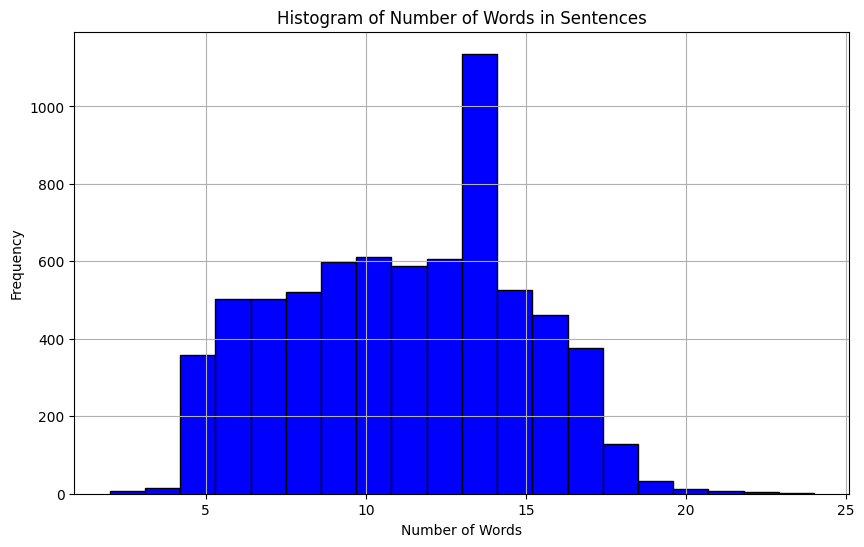

In [15]:
import matplotlib.pyplot as plt

word_counts = [len(sentence.split()) for sentence in all_sentence]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Number of Words in Sentences')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()


# Data Padding

In [21]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2024-08-10 17:38:36.971204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 17:38:36.971317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 17:38:37.085392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
max_len = 20


def pad_sentence(sentence, pos_tags, ner_tags, max_len, pad_token='PADword'):
    pad_length = max_len - len(sentence)
    
    if pad_length > 0:
        sentence += [pad_token] * pad_length
        pos_tags += ['PAD'] * pad_length
        ner_tags += ['O'] * pad_length 
    
    sentence = sentence[:max_len]
    pos_tags = pos_tags[:max_len]
    ner_tags = ner_tags[:max_len]
    
    return sentence, pos_tags, ner_tags


grouped = cleaned_data.groupby('Sentence_ID')
padded_sentences = []

for _, group in grouped:
    tokens = list(group['Token'])
    pos_tags = list(group['POS'])
    ner_tags = list(group['NER'])
    
    # padding
    padded_tokens, padded_pos, padded_ner = pad_sentence(tokens, pos_tags, ner_tags, max_len)
    
    sentence_tuples = list(zip(padded_tokens, padded_pos, padded_ner))
    
    padded_sentences.append(sentence_tuples)

padded_sentences_df = pd.DataFrame(padded_sentences)

padded_sentences[:2]


[[('শনিবার', 'NNP', 'B-D&T'),
  ('(২৭', 'PUNCT', 'B-OTH'),
  ('আগস্ট)', 'NNP', 'B-D&T'),
  ('রাতে', 'NNC', 'B-D&T'),
  ('পটুয়াখালী', 'NNP', 'B-GPE'),
  ('সদর', 'NNC', 'I-GPE'),
  ('থানার', 'NNC', 'I-GPE'),
  ('ভারপ্রাপ্ত', 'ADJ', 'B-PER'),
  ('কর্মকর্তা', 'NNC', 'I-PER'),
  ('(ওসি)', 'PUNCT', 'B-OTH'),
  ('মো.', 'NNP', 'B-PER'),
  ('মনিরুজ্জামান', 'NNP', 'I-PER'),
  ('এ', 'DET', 'B-OTH'),
  ('তথ্য', 'NNC', 'B-OTH'),
  ('নিশ্চিত', 'ADJ', 'B-OTH'),
  ('করেছেন।', 'VF', 'B-OTH'),
  ('PADword', 'PAD', 'O'),
  ('PADword', 'PAD', 'O'),
  ('PADword', 'PAD', 'O'),
  ('PADword', 'PAD', 'O')],
 [('বায়ুদূষণ', 'NNC', 'B-OTH'),
  ('ও', 'CONJ', 'B-OTH'),
  ('স্মার্ট', 'NNC', 'B-OTH'),
  ('ফোন', 'NNC', 'B-OTH'),
  ('ছেলেমেয়ে', 'NNC', 'B-PER'),
  ('উভয়ের', 'PRO', 'B-OTH'),
  ('প্রজনন', 'NNC', 'B-OTH'),
  ('ক্ষমতা', 'NNC', 'B-OTH'),
  ('হ্রাস', 'NNC', 'B-OTH'),
  ('করে', 'VNF', 'B-OTH'),
  ('দিচ্ছে।', 'VF', 'B-OTH'),
  ('PADword', 'PAD', 'O'),
  ('PADword', 'PAD', 'O'),
  ('PADword', 'PAD', 'O'),
  ('

In [24]:
max_len = 20
X = [[w[0]for w in s] for s in padded_sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[0]

['শনিবার',
 '(২৭',
 'আগস্ট)',
 'রাতে',
 'পটুয়াখালী',
 'সদর',
 'থানার',
 'ভারপ্রাপ্ত',
 'কর্মকর্তা',
 '(ওসি)',
 'মো.',
 'মনিরুজ্জামান',
 'এ',
 'তথ্য',
 'নিশ্চিত',
 'করেছেন।',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [25]:
unique_pos_tags = set()
unique_ner_tags = set()

for sentence in padded_sentences:
    for word, pos_tag, ner_tag in sentence:
        unique_pos_tags.add(pos_tag)
        unique_ner_tags.add(ner_tag)

pos_tags = sorted(list(unique_pos_tags))
ner_tags = sorted(list(unique_ner_tags))

word2idx = {w: i for i, w in enumerate(tokens)}
pos2idx = {p: i for i, p in enumerate(pos_tags)}
ner2idx = {n: i for i, n in enumerate(ner_tags)}

print("POS to index mapping:", pos2idx)
print("NER to index mapping:", ner2idx)


POS to index mapping: {'ADJ': 0, 'ADV': 1, 'CONJ': 2, 'DET': 3, 'INTJ': 4, 'NNC': 5, 'NNP': 6, 'OTH': 7, 'PAD': 8, 'PART': 9, 'PP': 10, 'PRO': 11, 'PUNCT': 12, 'QF': 13, 'VF': 14, 'VNF': 15}
NER to index mapping: {'B-D&T': 0, 'B-EVENT': 1, 'B-GPE': 2, 'B-LOC': 3, 'B-MISC': 4, 'B-NUM': 5, 'B-ORG': 6, 'B-OTH': 7, 'B-PER': 8, 'B-T&T': 9, 'B-UNIT': 10, 'I-D&T': 11, 'I-EVENT': 12, 'I-GPE': 13, 'I-LOC': 14, 'I-MISC': 15, 'I-NUM': 16, 'I-ORG': 17, 'I-PER': 18, 'I-T&T': 19, 'I-UNIT': 20, 'O': 21}


In [27]:
word2idx['<UNK>'] = len(word2idx)
word2idx['PADword'] = len(word2idx)
pos2idx['PADpos'] = len(pos2idx)
ner2idx['PADner'] = len(ner2idx)

max_len = 20

X = []
for s in padded_sentences:
    sentence_indices = []
    for w in s:
        if w in word2idx:
            sentence_indices.append(word2idx[w])
        else:
            sentence_indices.append(word2idx['<UNK>'])
    X.append(sentence_indices)

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PADword"])

y_pos = []
for s in padded_sentences:
    pos_indices = []
    for w in s:
        if w in pos2idx:
            pos_indices.append(pos2idx[w])
        else:
            pos_indices.append(pos2idx['PADpos'])
    y_pos.append(pos_indices)

y_pos = pad_sequences(maxlen=max_len, sequences=y_pos, padding="post", value=pos2idx["PADpos"])

y_ner = []
for s in padded_sentences:
    ner_indices = []
    for w in s:
        if w in ner2idx:
            ner_indices.append(ner2idx[w])
        else:
            ner_indices.append(ner2idx['PADner'])
    y_ner.append(ner_indices)

y_ner = pad_sequences(maxlen=max_len, sequences=y_ner, padding="post", value=ner2idx["PADner"])

# First split: 80% for training+validation, 20% for testing
X_train_val, X_test, y_pos_train_val, y_pos_test, y_ner_train_val, y_ner_test = train_test_split(
    X, y_pos, y_ner, test_size=0.2, random_state=2018)

# Second split: 80% of the original for training, 20% of the original for validation
X_train, X_val, y_pos_train, y_pos_val, y_ner_train, y_ner_val = train_test_split(
    X_train_val, y_pos_train_val, y_ner_train_val, test_size=0.25, random_state=2018)  # 0.25 is 20% of the original data size

# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_pos_train shape:", y_pos_train.shape)
print("y_pos_val shape:", y_pos_val.shape)
print("y_pos_test shape:", y_pos_test.shape)
print("y_ner_train shape:", y_ner_train.shape)
print("y_ner_val shape:", y_ner_val.shape)
print("y_ner_test shape:", y_ner_test.shape)

X_train shape: (4203, 20)
X_val shape: (1401, 20)
X_test shape: (1402, 20)
y_pos_train shape: (4203, 20)
y_pos_val shape: (1401, 20)
y_pos_test shape: (1402, 20)
y_ner_train shape: (4203, 20)
y_ner_val shape: (1401, 20)
y_ner_test shape: (1402, 20)


# Model Development

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
max_len = 20

# Model architecture
input = Input(shape=(max_len,))
model = Embedding(input_dim=len(word2idx), output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

out_pos = TimeDistributed(Dense(len(pos2idx), activation="softmax"))(model)
out_ner = TimeDistributed(Dense(len(ner2idx), activation="softmax"))(model)

model = Model(inputs=input, outputs=[out_pos, out_ner])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", "accuracy"])  

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 50)    │        700 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20, 50)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 200)   │    120,800 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 20, 17)    │      3,417 │ bidirectional[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 20, 23)    │      4,623 │ bidirectional[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 129,540 (506.02 KB)

 Trainable params: 129,540 (506.02 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [30]:
y_pos_train = y_pos_train.reshape((y_pos_train.shape[0], max_len, 1))
y_pos_val = y_pos_val.reshape((y_pos_val.shape[0], max_len, 1))
y_pos_test = y_pos_test.reshape((y_pos_test.shape[0], max_len, 1))

y_ner_train = y_ner_train.reshape((y_ner_train.shape[0], max_len, 1))
y_ner_val = y_ner_val.reshape((y_ner_val.shape[0], max_len, 1))
y_ner_test = y_ner_test.reshape((y_ner_test.shape[0], max_len, 1))

history = model.fit(X_train, [y_pos_train, y_ner_train], 
                    validation_data=(X_val, [y_pos_val, y_ner_val]), 
                    batch_size=32, epochs=1, verbose=1)



132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 1.2443 - time_distributed_1_accuracy: 0.9866 - time_distributed_accuracy: 0.9630 - val_loss: 3.7978e-04 - val_time_distributed_1_accuracy: 1.0000 - val_time_distributed_accuracy: 1.0000


In [31]:
results = model.evaluate(X_test, [y_pos_test, y_ner_test], verbose=1)

print("Evaluation results:", results)

test_loss = results[0]  # Total loss
test_pos_loss = results[1]  # Loss for POS tagging
test_ner_loss = results[2]  # Loss for NER

print("Test Loss:", test_loss)
print("Test POS Loss:", test_pos_loss)
print("Test NER Loss:", test_ner_loss)



44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7978e-04 - time_distributed_1_accuracy: 1.0000 - time_distributed_accuracy: 1.0000
Evaluation results: [0.0003797805111389607, 1.0, 1.0]
Test Loss: 0.0003797805111389607
Test POS Loss: 1.0
Test NER Loss: 1.0
